# ${\color{lightblue}Names:}$
* ${\color{yellow}Ehud\ Avrahami}$  

* ${\color{yellow}Daniel\ Lyumet}$  



# The final audio files are located in my public git repository, link down below:
https://github.com/zomb1egg/dsp  <br>
the audio files are labeled:  <br>
reconstructed_signal_with_threshold_{threshold_value}.wav  <br>
the threshold value of 0 is the reconstruction without threshold  <br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from tqdm import tqdm
from scipy.integrate import quad

MUSIC_PATH = "./strangemusic.wmv"

# comment this line if ffmpeg is not present.
# pydub.AudioSegment.ffmpeg = "C:/ProgramData/chocolatey/bin/ffmpeg.exe"

c:\Program Files\python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


each time the signal is between $\frac{k}{2^j}$ and $\frac{k+1}{2^j}$, meaning our last $k$ is when $\frac{k+1}{2^j} = 1 => k = 2^j - 1$

In [2]:
# Define the Haar scaling function φ(t)
def phi(t):
    return np.where((t >= 0) & (t < 1), 1, 0)

# Define the Haar wavelet function ψ(t)
def psi(t):
    return np.where((t >= 0) & (t < 0.5), 1, np.where((t >= 0.5) & (t < 1), -1, 0))

# Define the scaled and translated versions
def phi_jk(t, j, k):
    return 2**(j/2) * phi(2**j * t - k)

def psi_jk(t, j, k):
    return 2**(j/2) * psi(2**j * t - k)

# Compute wavelet coefficients using integration
def approximation_coefficient(func, j, k):
    return quad(lambda t: func(t) * phi_jk(t, j, k), k / (2**j), (k + 1) / (2 ** j))[0]
def detail_coefficient(func, j, k):    
    return quad(lambda t: func(t) * psi_jk(t, j, k), k / (2**j), (k + 1) / (2 ** j))[0]

def bound_detail_coefficient(func, j, k, threshold):
    djk = detail_coefficient(func, j, k)
    return djk if np.abs(djk) >= threshold else 0

def create_coefficients(signal, j, threshold=0, L1=0, L2=1):
    cjk = []
    djk = []
    for k in tqdm(range(2**j + 1)):
        cjk.append(approximation_coefficient(signal, j, k))
        d_j_tag_k = []
        for j_tag in range(j + 1):  # j' = 0 -> j
            _djk = bound_detail_coefficient(signal, j_tag, k, threshold)
            d_j_tag_k.append(_djk)
        djk.append(d_j_tag_k)
    
    return np.array(cjk), np.array(djk)

In [45]:
def reconstruct_using_coefficients(func, linspace, j, L1, L2):
    x_reconstructed = np.zeros_like(linspace) 
    for k in tqdm(range(L1 * 2**j, L2 * 2**j)):  # k = 0 -> j
        x_reconstructed += approximation_coefficient(func, 0, k) * phi_jk(linspace, 0, k)
       
    for k in tqdm(range(L1 * 2**j, L2 * 2**j)):  # k = 0 -> j
        for j_tag in range(j + 1):  # j' = 0 -> j
            x_reconstructed += detail_coefficient(func, j_tag, k) * psi_jk(linspace, j_tag, k)
            
    return x_reconstructed


def reconstruct_using_coefficients_doesnt_work(func, linspace, j, L1, L2):
    x_reconstructed = np.zeros_like(linspace) 
    for k in tqdm(range(L1 * 2**j, L2 * 2**j)):  # k = 0 -> j
        x_reconstructed += approximation_coefficient(func, j, k) * phi_jk(linspace, j, k)
       
    for k in tqdm(range(L1 * 2**j, L2 * 2**j)):  # k = 0 -> j
        for j_tag in range(j + 1):  # j' = 0 -> j
            x_reconstructed += detail_coefficient(func, j_tag, k) * psi_jk(linspace, j_tag, k)
            
    return x_reconstructed

In [49]:
# discrete reconstruction:
j = 2
t = np.linspace(0, 1, 1000, endpoint=False)
x = lambda t: np.where((t >= 0) & (t < 0.5), 0, np.where((t >= 0.5) & (t < 1), 1, 0))
x_discrete = x(t)


### this is the reconstruction with the formula provided in the pdf.
### we couldn't quite manage to make it work, and so we moved on to the formula that we did manage to prove.
### for more information please refer to the pdf. (at section)

100%|██████████| 4/4 [00:00<00:00, 1000.13it/s]


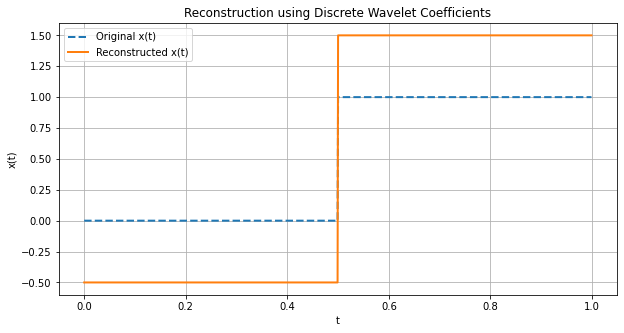

In [ ]:
x_reconstructed = reconstruct_using_coefficients_doesnt_work(x, t, j, 0, 1)
plt.figure(figsize=(10, 5))
plt.plot(t, x(t), label='Original x(t)', linestyle='dashed', linewidth=2)
plt.plot(t, x_reconstructed, label='Reconstructed x(t)', linewidth=2)
plt.legend()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Reconstruction using Discrete Wavelet Coefficients')
plt.grid()
plt.show()

100%|██████████| 4/4 [00:00<00:00, 879.68it/s]


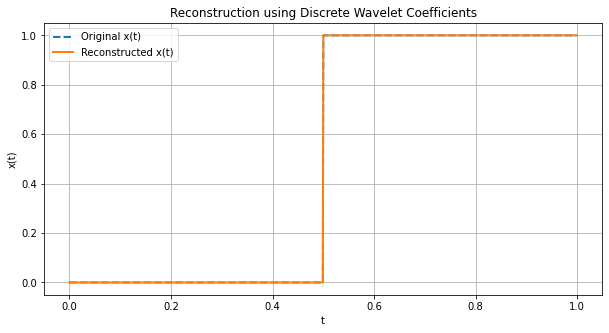

In [ ]:
x_reconstructed_ = reconstruct_using_coefficients(x, t, j, 0, 1)
plt.figure(figsize=(10, 5))
plt.plot(t, x(t), label='Original x(t)', linestyle='dashed', linewidth=2)
plt.plot(t, x_reconstructed_, label='Reconstructed x(t)', linewidth=2)
plt.legend()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Reconstruction using Discrete Wavelet Coefficients')
plt.grid()
plt.show()

In [5]:
def compute_haar_coefficients(signal, level, threshold = 0):
    detail_coefficients = []
    leftover_values = []  # Store extra values that cannot be decomposed

    approximation_coefficient = signal.copy()  # Start with the original signal

    for i in tqdm(range(level)):
        n = len(approximation_coefficient)

        if n < 2:
            break  # Stop if we cannot decompose further

        if n % 2 == 1:  # If length is odd, keep last element aside
            leftover_values.append(approximation_coefficient[-1])
            approximation_coefficient = approximation_coefficient[:-1]  # Remove last element

        # Compute approximation and detail coefficients
        new_approximation = (approximation_coefficient[::2] + approximation_coefficient[1::2]) / np.sqrt(2)
        new_detail = (approximation_coefficient[::2] - approximation_coefficient[1::2]) / np.sqrt(2)

        if threshold > 0:
            new_detail = np.where(np.abs(new_detail) >= threshold, new_detail, 0)
        detail_coefficients.append(new_detail)
        approximation_coefficient = new_approximation  # Update for next level

    return approximation_coefficient, detail_coefficients[::-1], leftover_values

def inverse_haar_coefficients(s_levels, d_levels):
    reconstructed = s_levels
    max_len = len(d_levels)

    # Iterate through levels to reconstruct step by step
    for i in tqdm(range(max_len)):
        s = reconstructed  # Current approximation coefficients
        d = d_levels[i]  # Corresponding detail coefficients at this level

        # Apply inverse Haar transformation
        n = s.shape[0]
        x = np.zeros(2 * n)
            
        for j in range(min(n, len(d))):  # iterate through the minimum index, so we have enough variable in case of padding.
            x[2 * j] = (s[j] + d[j]) / np.sqrt(2)  # Even index
            x[2 * j + 1] = (s[j] - d[j]) / np.sqrt(2)  # Odd index

        # Update for next level
        reconstructed = x

    return reconstructed

# Section 4.2.5 (a)

In [ ]:
audio = AudioSegment.from_file(MUSIC_PATH)

def scale_audio(audio):
    return min_max_scale(np.array(audio.get_array_of_samples(), dtype=np.float32)), audio.frame_rate * 2

def min_max_scale(audio, _min = -1, _max = 1):
    array_min = np.min(audio)
    array_max = np.max(audio)
    return _min + ((audio - array_min) / (array_max - array_min)) * (_max - _min)
    
orig_audio_np, sr = scale_audio(audio)

# Section 4.2.5 (b)

In [66]:
def mean_squared_error(audio, original_audio):
    return np.sum((audio - original_audio) ** 2) / audio.shape[0]

def calculate_compression_ratio(approx_coefficients, detail_coefficients):
    total = approx_coefficients.shape[0]
    nonzero_count = np.count_nonzero(approx_coefficients)
    for detail_coefficient in detail_coefficients:
        total += detail_coefficient.shape[0]
        nonzero_count += np.count_nonzero(detail_coefficient)

    return (nonzero_count / total)

j = 2
audio_np = orig_audio_np
write(f"original_normalized_audio.wav", sr, (audio_np * 32767).astype(np.int16))

N = audio_np.shape[0]

t = np.linspace(0, 1, N)

In [67]:
def display_haar_inverse(signal, t, j, threshold=0):
    coefficients = compute_haar_coefficients(signal, j, threshold)
    reconstructed_audio = inverse_haar_coefficients(coefficients[0], coefficients[1])

    # Plot original and reconstructed function
    plt.figure(figsize=(10, 5))
    plt.plot(t, audio_np, label='Original x(t)', linestyle='dashed', linewidth=2)
    plt.plot(t, reconstructed_audio, label='Reconstructed x(t)', linewidth=2)
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.title('Original vs Reconstructed Signal using Haar Wavelet')
    plt.grid()
    plt.show()
    
    write(f"reconstructed_signal_with_threshold_{threshold}.mp3", sr, (reconstructed_audio * 32767).astype(np.int16))

    print(f"MSE: {mean_squared_error(reconstructed_audio, audio_np)}")
    print(f"compression ratio: {calculate_compression_ratio(coefficients[0], coefficients[1]) * 100}%")

100%|██████████| 2/2 [00:00<00:00, 21.79it/s]


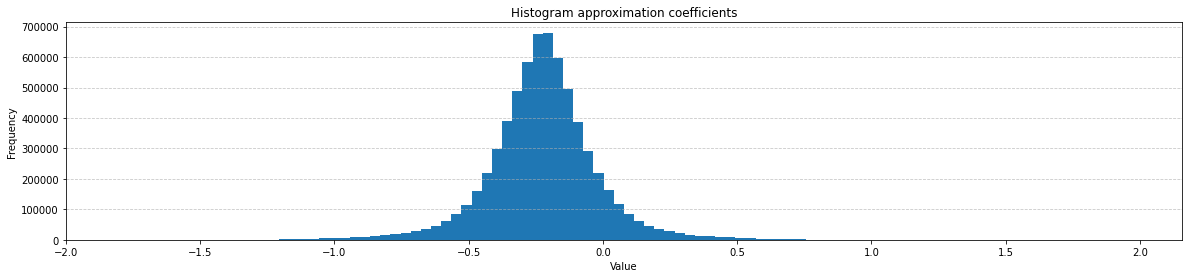

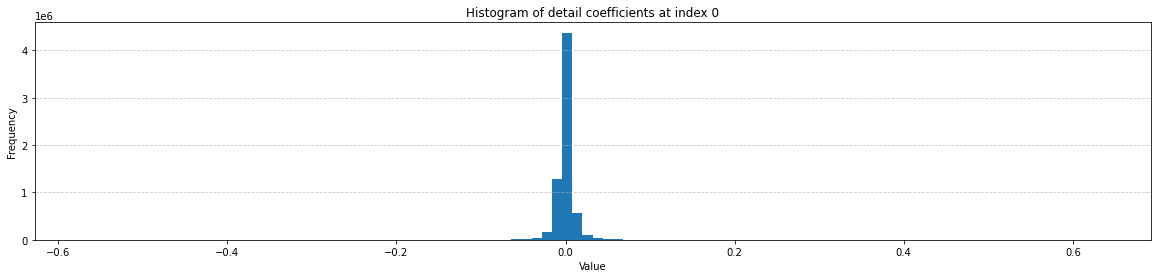

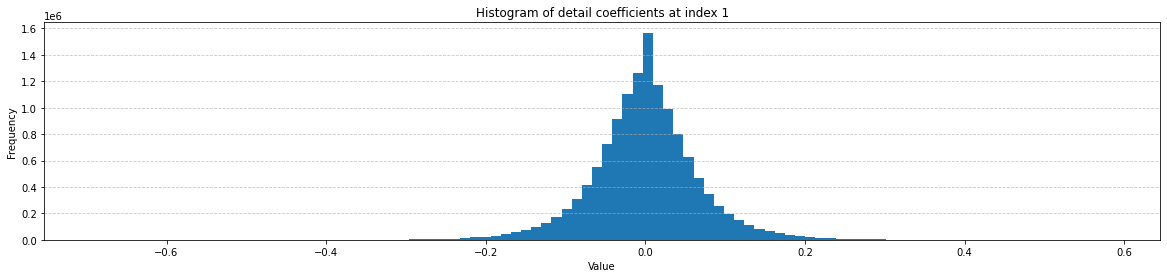

In [68]:
coefficients = compute_haar_coefficients(audio_np, j)

# let us plot the histogram of all the coefficients
plt.figure(figsize=(20, 4))  # Create a new figure for each histogram
plt.hist(coefficients[0], bins=100)
plt.title(f'Histogram approximation coefficients')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
for i in range(len(coefficients[1])):
    plt.figure(figsize=(20, 4))  # Create a new figure for each histogram
    plt.hist(coefficients[1][i], bins=100)
    plt.title(f'Histogram of detail coefficients at index {i}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:48<00:00, 24.12s/it]


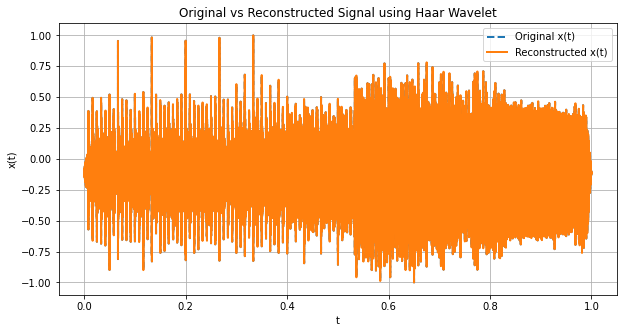

MSE: 8.808124539805673e-17
compression ratio: 99.80622211981344%


In [69]:
# we can see that without the threshold the audio is barely compressed but its accuracy is high
display_haar_inverse(audio_np, t, j, threshold=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:48<00:00, 24.29s/it]


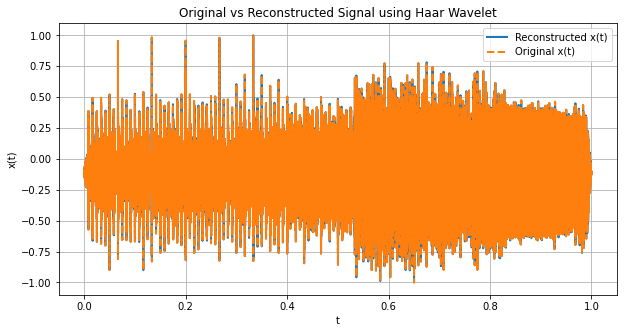

MSE: 1.7779943700609786e-08
compression ratio: 94.0895327437974%


In [ ]:
display_haar_inverse(audio_np, t, j, threshold=0.001)

100%|██████████| 2/2 [00:46<00:00, 23.27s/it]


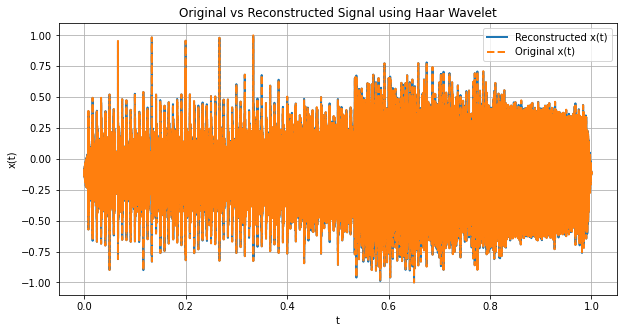

MSE: 6.361420000503017e-06
compression ratio: 70.26071225107408%


In [ ]:
display_haar_inverse(audio_np, t, j, threshold=0.01)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:48<00:00, 24.37s/it]


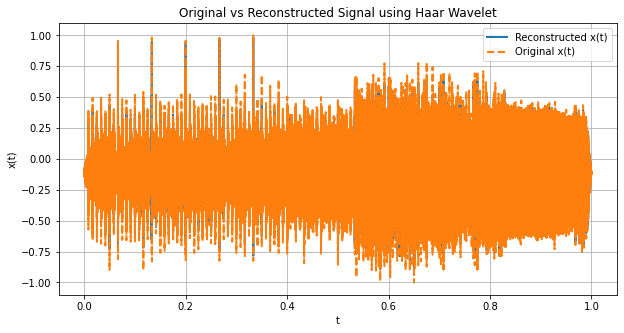

MSE: 0.002195912229445463
compression ratio: 25.0%


In [ ]:
# and if we filter out all the detail coefficients we will receive something like that:
display_haar_inverse(audio_np, t, j, threshold=10)
# we personally have not managed to perceive a drastic difference, but we do see that it is compressed much more than the other tracks. 

Reconstructing Image: 100%|██████████| 2/2 [00:00<00:00, 199.54it/s]


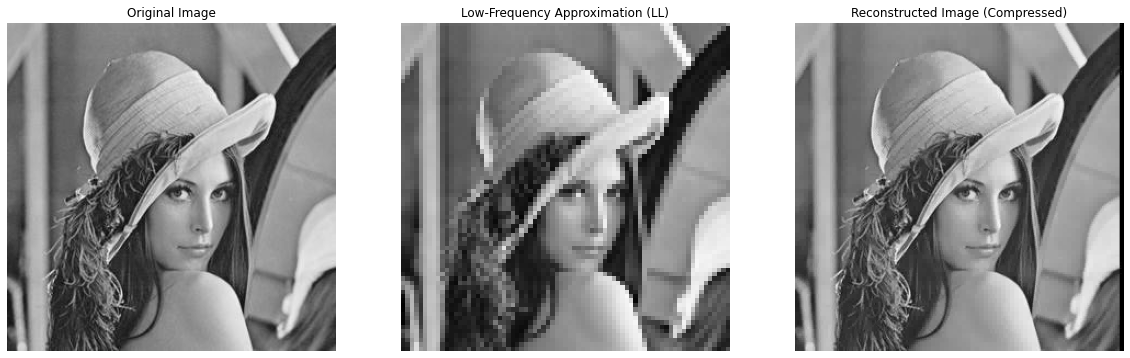

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_haar_2d(image, level=1, threshold=0):
    image = image.astype(np.float32)

    approx = image.copy()
    details = []

    for i in tqdm(range(level), desc="Applying Haar Transform"):
        rows, cols = approx.shape

        # Apply 1D Haar transform along rows
        row_approx = np.zeros((rows // 2, cols))
        row_detail = np.zeros((rows // 2, cols))

        for j in range(0, rows - 1, 2):
            row_approx[j // 2, :] = (approx[j, :] + approx[j + 1, :]) / np.sqrt(2)
            row_detail[j // 2, :] = (approx[j, :] - approx[j + 1, :]) / np.sqrt(2)

        # Apply 1D Haar transform along columns
        col_approx = np.zeros((rows // 2, cols // 2))
        LH = np.zeros((rows // 2, cols // 2))
        HL = np.zeros((rows // 2, cols // 2))
        HH = np.zeros((rows // 2, cols // 2))

        for j in range(0, cols - 1, 2):
            col_approx[:, j // 2] = (row_approx[:, j] + row_approx[:, j + 1]) / np.sqrt(2)
            LH[:, j // 2] = (row_approx[:, j] - row_approx[:, j + 1]) / np.sqrt(2)
            HL[:, j // 2] = (row_detail[:, j] + row_detail[:, j + 1]) / np.sqrt(2)
            HH[:, j // 2] = (row_detail[:, j] - row_detail[:, j + 1]) / np.sqrt(2)

        # Apply thresholding for compression
        if threshold > 0:
            LH[np.abs(LH) < threshold] = 0
            HL[np.abs(HL) < threshold] = 0
            HH[np.abs(HH) < threshold] = 0

        details.append((LH, HL, HH))
        approx = col_approx  # Update for next level

    return approx, details

def inverse_haar_2d(approx, details):
    reconstructed = approx
    levels = len(details)

    for i in tqdm(range(levels - 1, -1, -1), desc="Reconstructing Image"):
        LH, HL, HH = details[i]
        rows, cols = LH.shape

        row_approx = np.zeros((rows, cols * 2))
        row_detail = np.zeros((rows, cols * 2))

        for j in range(cols - 1):
            row_approx[:, 2 * j] = (reconstructed[:, j] + LH[:, j]) / np.sqrt(2)
            row_approx[:, 2 * j + 1] = (reconstructed[:, j] - LH[:, j]) / np.sqrt(2)
            row_detail[:, 2 * j] = (HL[:, j] + HH[:, j]) / np.sqrt(2)
            row_detail[:, 2 * j + 1] = (HL[:, j] - HH[:, j]) / np.sqrt(2)

        full_reconstructed = np.zeros((rows * 2, cols * 2))

        for j in range(rows):
            full_reconstructed[2 * j, :] = (row_approx[j, :] + row_detail[j, :]) / np.sqrt(2)
            full_reconstructed[2 * j + 1, :] = (row_approx[j, :] - row_detail[j, :]) / np.sqrt(2)

        reconstructed = full_reconstructed  # Update for next level

    return np.clip(reconstructed, 0, 255).astype(np.uint8)

image_path = "image.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)[:1060, :850]

approx, details = compute_haar_2d(image, level=2, threshold=10)

reconstructed_image = inverse_haar_2d(approx, details)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(approx, cmap='gray')
ax[1].set_title("Low-Frequency Approximation (LL)")
ax[1].axis("off")

ax[2].imshow(reconstructed_image, cmap='gray')
ax[2].set_title("Reconstructed Image (Compressed)")
ax[2].axis("off")

plt.show()
